# Mini-projet : Analyse temporelle du Bitcoin (1-min OHLCV)

> Cours 8PRO408 — Outils de programmation pour la science des données

Ce notebook suit les consignes du mini-projet :
- préparer et inspecter un jeu de données Bitcoin à la minute (1-min OHLCV) ;
- effectuer les agrégations horaire, journalière et mensuelle avec statistiques clés ;
- analyser tendances, volatilité et relation prix/volume ;
- produire les visualisations demandées (courbes temporelles, heatmap, graphiques interactifs) ;
- résumer les principaux constats et limites.

⚠️ **Pré-requis** : placer le fichier 1-min OHLCV téléchargé depuis Kaggle (lien fourni dans l'énoncé) dans `../data/BTC-USD_1min.csv`.

In [26]:
# Imports et configuration de base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from pathlib import Path

plt.style.use("seaborn-v0_8")
sns.set_theme(style="darkgrid")

DATA_DIR = Path("data")
RAW_PATH = DATA_DIR / "btcusd_1-min_data.csv"  # fichier téléchargé depuis Kaggle
CACHE_DIR = Path("figures")
CACHE_DIR.mkdir(parents=True, exist_ok=True)

pd.options.display.float_format = "{:.4f}".format

In [27]:
# Chargement des données 1-min et contrôles de base
if not RAW_PATH.exists():
    raise FileNotFoundError("Placez le fichier 1-min Kaggle dans data/BTC-USD_1min.csv")

dtypes = {
    "Timestamp": "float64",
    "Open": "float32",
    "High": "float32",
    "Low": "float32",
    "Close": "float32",
    "Volume": "float32",
}
df = pd.read_csv(
    RAW_PATH,
    usecols=["Timestamp", "Open", "High", "Low", "Close", "Volume"],
    dtype=dtypes,
)

# Convertit la colonne Timestamp (epoch en secondes) en datetime
if pd.api.types.is_datetime64_any_dtype(df["Timestamp"]):
    dt_series = df["Timestamp"]
else:
    dt_series = pd.to_datetime(df["Timestamp"], unit="s", errors="coerce")

# Trie, indexe et purge les dates invalides pour fiabiliser les analyses ultérieures
df = df.assign(Timestamp=dt_series).dropna(subset=["Timestamp"]).sort_values("Timestamp")
df = df.set_index("Timestamp")
if not isinstance(df.index, pd.DatetimeIndex):
    df.index = pd.to_datetime(df.index, errors="coerce")
    df = df[~df.index.isna()]
df = df.sort_index()

print("\n=== Aperçu info() ===")
df.info(memory_usage="deep")

print("\n=== Statistiques descriptives (1-min) ===")
display(df.describe().T)

nb_rows = len(df)
missing_any = df.isna().sum().sum()
dup_count = df.index.duplicated(keep="first").sum()
time_gaps = df.index.to_series().diff().gt(pd.Timedelta(minutes=1)).sum()

print(f"Lignes totales : {nb_rows:,}")
print(f"Valeurs manquantes totales : {missing_any:,}")
print(f"Index dupliqués : {dup_count:,}")
print(f"Sauts de plus d'une minute : {time_gaps:,}")
display(df.head())


=== Aperçu info() ===
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7332157 entries, 2012-01-01 10:01:00 to 2025-12-10 23:57:00
Data columns (total 5 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Open    float32
 1   High    float32
 2   Low     float32
 3   Close   float32
 4   Volume  float32
dtypes: float32(5)
memory usage: 195.8 MB

=== Statistiques descriptives (1-min) ===


,count,mean,std,min,25%,50%,75%,max
Open,7332157.0000,21385.9531,30049.0684,3.8000,443.8800,7303.5898,31053.9805,126202.0000
High,7332157.0000,21393.6309,30057.2734,3.8000,444.0000,7307.9902,31074.0000,126272.0000
Low,7332157.0000,21378.0742,30040.7480,3.8000,443.6700,7299.8198,31037.0000,126158.0000
Close,7332157.0000,21385.9629,30049.0723,3.8000,443.8800,7303.5298,31054.8691,126202.0000
Volume,7332157.0000,5.1228,22.0470,0.0000,0.0198,0.4491,2.8953,5853.8521


Lignes totales : 7,332,157
Valeurs manquantes totales : 0
Index dupliqués : 0
Sauts de plus d'une minute : 1


,Open,High,Low,Close,Volume
Timestamp,,,,,
2012-01-01 10:01:00,4.5800,4.5800,4.5800,4.5800,0.0000
2012-01-01 10:02:00,4.5800,4.5800,4.5800,4.5800,0.0000
2012-01-01 10:03:00,4.5800,4.5800,4.5800,4.5800,0.0000
2012-01-01 10:04:00,4.5800,4.5800,4.5800,4.5800,0.0000
2012-01-01 10:05:00,4.5800,4.5800,4.5800,4.5800,0.0000


## Contrôles de qualité initiaux
Le chargement ci-dessus affiche `info()` et `describe()` pour vérifier types, volumes mémoire et statistiques de base. Les impressions finales résument la taille du jeu, les valeurs manquantes, les doublons et les sauts de temps éventuels avant de poursuivre l'analyse.

## Agrégations horaire / journalière / mensuelle
La cellule suivante prépare three DataFrames (`hourly`, `daily`, `monthly`) en regroupant le prix et le volume par heure, jour et mois. Les colonnes composites comme `Close_mean` ou `Close_std` correspondent respectivement à la moyenne et à l'écart-type de clôture sur la période agrégée.

In [28]:
# Agrégations temporelles (heure, jour, mois)
agg_config = {
    "Open": ["first","max"],
    "High": "max",
    "Low": "min",
    "Close": ["last","mean","std"],
    "Volume": "sum"
}

hourly = df.resample("1H").agg(agg_config)
daily = df.resample("1D").agg(agg_config)
monthly = df.resample("1M").agg(agg_config)

def flatten_columns(frame: pd.DataFrame) -> pd.DataFrame:
    frame = frame.copy()
    frame.columns = ["_".join(col).strip("_") if isinstance(col, tuple) else col for col in frame.columns]
    return frame

hourly = flatten_columns(hourly).dropna(how="all")
daily = flatten_columns(daily).dropna(how="all")
monthly = flatten_columns(monthly).dropna(how="all")

print("Heures: ", hourly.shape, "| Jours:", daily.shape, "| Mois:", monthly.shape)
display(hourly.head(3))
display(daily.head(3))
display(monthly.head(3))

C:\Users\viann\AppData\Local\Temp\ipykernel_31220\1655311033.py:10: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

C:\Users\viann\AppData\Local\Temp\ipykernel_31220\1655311033.py:12: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

C:\Users\viann\AppData\Local\Temp\ipykernel_31220\1655311033.py:12: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



Heures:  (122222, 8) | Jours: (5093, 8) | Mois: (168, 8)


,Open_first,Open_max,High_max,Low_min,Close_last,Close_mean,Close_std,Volume_sum
Timestamp,,,,,,,,
2012-01-01 10:00:00,4.5800,4.5800,4.5800,4.5800,4.5800,4.5800,0.0000,0.0000
2012-01-01 11:00:00,4.5800,4.5800,4.5800,4.5800,4.5800,4.5800,0.0000,0.0000
2012-01-01 12:00:00,4.5800,4.5800,4.5800,4.5800,4.5800,4.5800,0.0000,0.0000


,Open_first,Open_max,High_max,Low_min,Close_last,Close_mean,Close_std,Volume_sum
Timestamp,,,,,,,,
2012-01-01,4.5800,4.8400,4.8400,4.5800,4.8400,4.6457,0.1131,10.0000
2012-01-02,4.8400,5.0000,5.0000,4.8400,5.0000,4.9750,0.0581,10.1000
2012-01-03,5.0000,5.3200,5.3200,5.0000,5.2900,5.0855,0.1330,107.0853


,Open_first,Open_max,High_max,Low_min,Close_last,Close_mean,Close_std,Volume_sum
Timestamp,,,,,,,,
2012-01-31,4.5800,7.3800,7.3800,3.8000,5.5500,6.2538,0.7056,2012.2534
2012-02-29,5.5500,6.5000,6.5000,3.8000,4.9900,5.2345,0.5955,4761.6089
2012-03-31,4.9900,5.4400,5.4400,4.5400,4.9200,4.9545,0.2211,9049.6260


## Indicateurs de tendance et volatilité
Les nouvelles colonnes calculées (`return`, `log_return`, `rolling_vol_60min`, `rolling_vol_1d`, `rolling_mean_1d`) servent à suivre le rendement instantané et la volatilité glissante. L'écart-type glissant des log-returns est utilisé comme mesure de volatilité, ce que l'on visualisera plus bas.

In [29]:
# Indicateurs de tendance et volatilité
df_features = df.copy()
df_features["return"] = df_features["Close"].pct_change()
df_features["log_return"] = np.log(df_features["Close"]).diff()
df_features["rolling_vol_60min"] = df_features["log_return"].rolling(window=60, min_periods=30).std()
df_features["rolling_vol_1d"] = df_features["log_return"].rolling(window=60*24, min_periods=60).std()
df_features["rolling_mean_1d"] = df_features["Close"].rolling(window=60*24, min_periods=60).mean()

feature_summary = df_features[["return","log_return","rolling_vol_60min","rolling_vol_1d"]].describe().T
display(feature_summary)

,count,mean,std,min,25%,50%,75%,max
return,7332156.0000,0.0000,0.0018,-0.4605,-0.0002,0.0000,0.0002,0.8532
log_return,7332156.0000,0.0000,0.0018,-0.6171,-0.0002,0.0000,0.0002,0.6169
rolling_vol_60min,7332127.0000,0.0011,0.0014,0.0000,0.0005,0.0008,0.0014,0.1169
rolling_vol_1d,7332097.0000,0.0013,0.0012,0.0000,0.0007,0.0010,0.0015,0.0347


In [30]:
# Corrélation simple prix / volume (échantillonnée en 15 minutes pour lisibilité)
sampled = df.resample("15T").agg({"Close": "last", "Volume": "sum"}).dropna()
corr_value = sampled["Close"].corr(sampled["Volume"])
print(f"Corrélation Close vs Volume (15 min): {corr_value:.3f}")
display(sampled.describe())

C:\Users\viann\AppData\Local\Temp\ipykernel_31220\3926699353.py:2: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.



Corrélation Close vs Volume (15 min): -0.175


,Close,Volume
count,488812.0000,488812.0000
mean,21386.2656,76.8424
std,30049.4219,176.0707
min,4.1400,0.0000
25%,443.8800,7.5726
50%,7304.7849,26.7771
75%,31050.0000,76.6048
max,126111.0000,11166.6904


## Visualisations statiques et zoom
Les graphiques suivants illustrent (1) l'évolution complète du prix, (2) un zoom sur le bull run 2017, (3) l'activité de volume agrégé, (4) les profils de volatilité glissante et (5) la distribution des log-returns centrée sur les valeurs les plus probables.

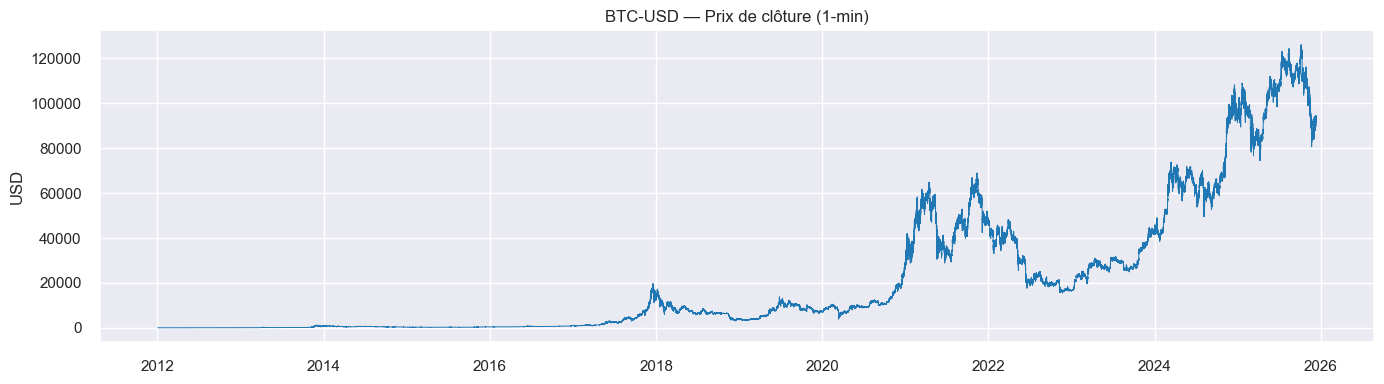

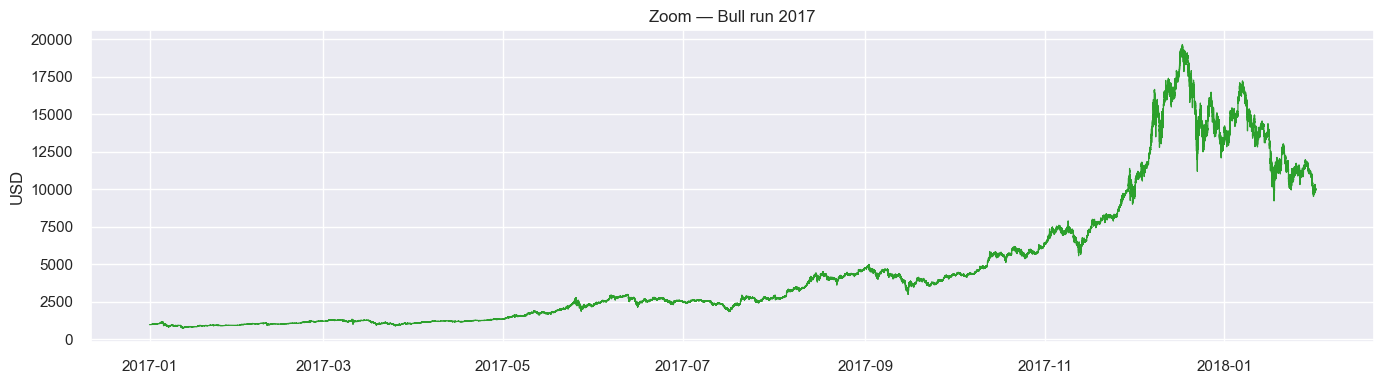

C:\Users\viann\AppData\Local\Temp\ipykernel_31220\628610749.py:24: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



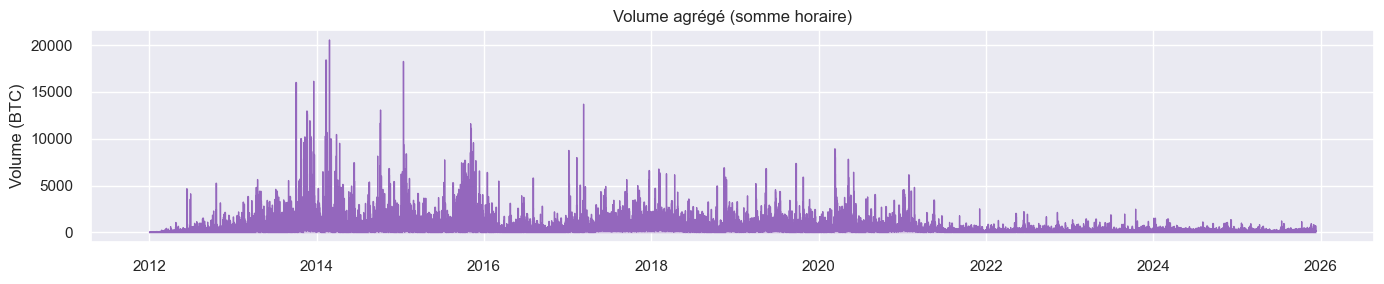

C:\Users\viann\AppData\Local\Temp\ipykernel_31220\628610749.py:48: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



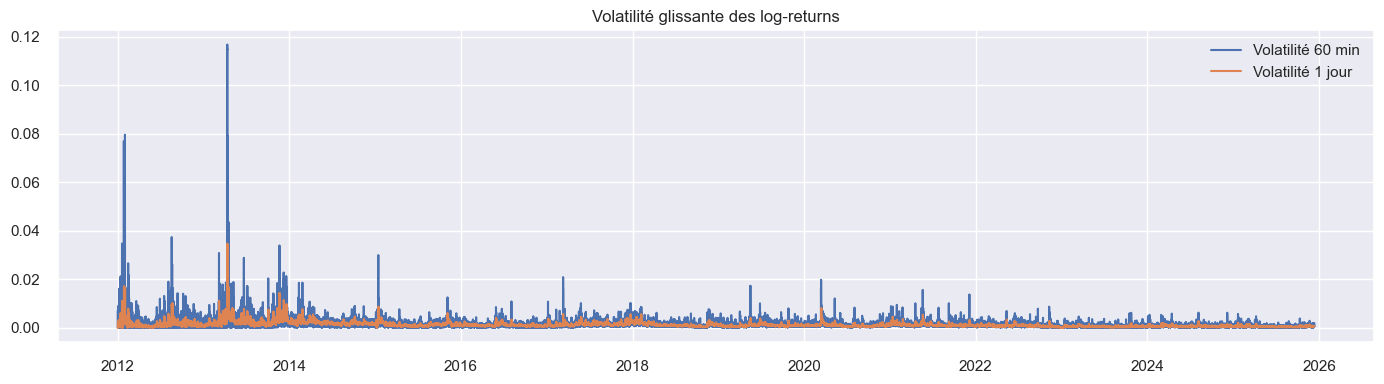

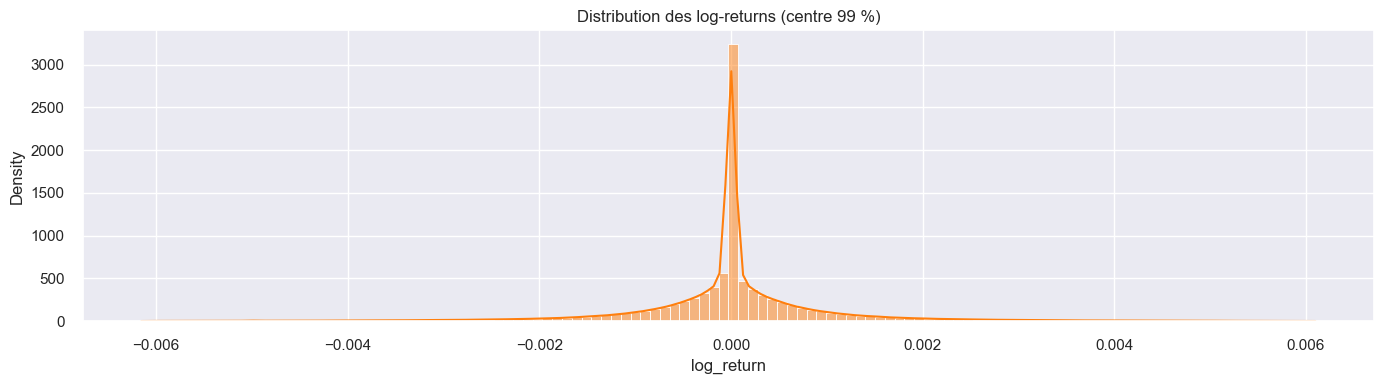

In [31]:
# Visualisations statiques essentielles
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(df.index, df["Close"], color="tab:blue", linewidth=0.7)
ax.set_title("BTC-USD — Prix de clôture (1-min)")
ax.set_ylabel("USD")
plt.tight_layout()
fig.savefig(CACHE_DIR / "close_price.png", dpi=120)
plt.show()

# Zoom sur le bull run 2017 pour illustrer les phases marquantes
bull_run = df.loc["2017-01-01":"2018-01-31", "Close"]
if bull_run.empty:
    print("Aucune donnée disponible pour la fenêtre 2017-01-01 -> 2018-01-31.")
else:
    fig, ax = plt.subplots(figsize=(14, 4))
    ax.plot(bull_run.index, bull_run, color="tab:green", linewidth=0.9)
    ax.set_title("Zoom — Bull run 2017")
    ax.set_ylabel("USD")
    plt.tight_layout()
    fig.savefig(CACHE_DIR / "close_price_bullrun_2017.png", dpi=120)
    plt.show()

# Volume agrégé à l'heure pour lisibilité
volume_hourly = df["Volume"].resample("1H").sum()
fig, ax = plt.subplots(figsize=(14, 3))
ax.fill_between(volume_hourly.index, volume_hourly, color="tab:purple", alpha=0.25)
ax.plot(volume_hourly.index, volume_hourly, color="tab:purple", linewidth=0.9)
ax.set_title("Volume agrégé (somme horaire)")
ax.set_ylabel("Volume (BTC)")
plt.tight_layout()
fig.savefig(CACHE_DIR / "volume_hourly.png", dpi=120)
plt.show()

fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(
    df_features.index,
    df_features["rolling_vol_60min"],
    label="Volatilité 60 min",
)
ax.plot(
    df_features.index,
    df_features["rolling_vol_1d"],
    label="Volatilité 1 jour",
)
ax.set_title("Volatilité glissante des log-returns")
ax.legend()
plt.tight_layout()
fig.savefig(CACHE_DIR / "rolling_vol.png", dpi=120)
plt.show()

# Distribution centrée pour mettre en évidence la forme de la densité
log_ret = df_features["log_return"].dropna()
low, high = log_ret.quantile([0.005, 0.995])
log_ret_central = log_ret[(log_ret >= low) & (log_ret <= high)]
fig, ax = plt.subplots(figsize=(14, 4))
sns.histplot(
    log_ret_central,
    bins=120,
    stat="density",
    kde=True,
    ax=ax,
    color="tab:orange",
)
ax.set_title("Distribution des log-returns (centre 99 %)")
ax.set_xlabel("log_return")
plt.tight_layout()
fig.savefig(CACHE_DIR / "log_returns_dist.png", dpi=120)
plt.show()

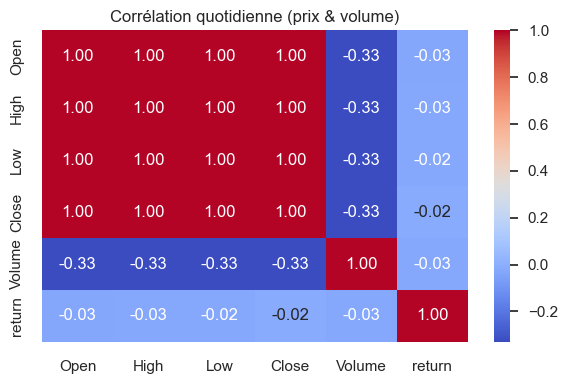

In [32]:
# Heatmap de corrélation (fenêtre quotidienne)
daily_features = df.resample("1D").agg({
    "Open": "first",
    "High": "max",
    "Low": "min",
    "Close": "last",
    "Volume": "sum"
}).dropna()
daily_features["return"] = daily_features["Close"].pct_change()
daily_features.index.name = "Date"
corr = daily_features.corr()
fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", ax=ax)
ax.set_title("Corrélation quotidienne (prix & volume)")
plt.tight_layout()
fig.savefig(CACHE_DIR / "corr_heatmap.png", dpi=120)
plt.show()

## Corrélations sur métriques dérivées
Pour clarifier les abréviations utilisées :
- `pct_return` : rendement relatif entre deux jours successifs (`Close_t / Close_{t-1} - 1`).
- `hl_range` : amplitude journalière (`High - Low`).
- `co_delta` : différence clôture - ouverture.
- `volume_z` : volume normalisé (score-z), utile pour comparer les journées indépendamment de l'échelle absolue.
La heatmap suivante aide à visualiser les relations entre ces indicateurs et le volume brut.

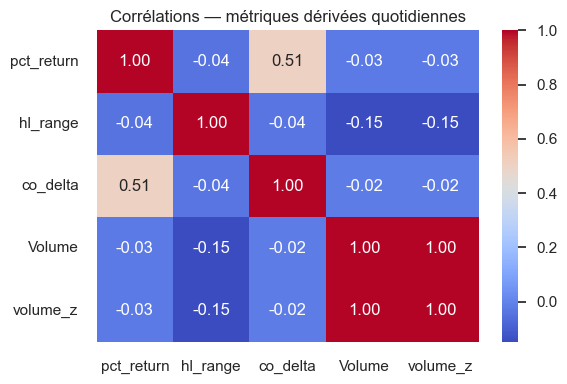

,pct_return,hl_range,co_delta,Volume,volume_z
pct_return,1.0000,-0.0414,0.5075,-0.0253,-0.0253
hl_range,-0.0414,1.0000,-0.0389,-0.1485,-0.1485
co_delta,0.5075,-0.0389,1.0000,-0.0213,-0.0213
Volume,-0.0253,-0.1485,-0.0213,1.0000,1.0000
volume_z,-0.0253,-0.1485,-0.0213,1.0000,1.0000


In [33]:
# Tableau de corrélations sur des métriques dérivées
derived_daily = daily_features.copy()
derived_daily["pct_return"] = derived_daily["Close"].pct_change()
derived_daily["hl_range"] = derived_daily["High"] - derived_daily["Low"]
derived_daily["co_delta"] = derived_daily["Close"] - derived_daily["Open"]
derived_daily["volume_z"] = (derived_daily["Volume"] - derived_daily["Volume"].mean()) / derived_daily["Volume"].std()
corr_derived = derived_daily[["pct_return", "hl_range", "co_delta", "Volume", "volume_z"]].dropna().corr()

fig, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(corr_derived, annot=True, fmt=".2f", cmap="coolwarm", ax=ax)
ax.set_title("Corrélations — métriques dérivées quotidiennes")
plt.tight_layout()
fig.savefig(CACHE_DIR / "corr_heatmap_derived.png", dpi=120)
plt.show()

display(corr_derived)

In [34]:
# Visualisation interactive (Plotly)
daily_reset = daily_features.reset_index()
fig = px.line(
    daily_reset,
    x="Date",
    y="Close",
    title="BTC-USD — prix de clôture (agrégation quotidienne)",
    labels={"Date": "Date", "Close": "USD"}
 )
fig.update_layout(template="plotly_white")
fig.show()

## Synthèse et pistes

- Le prix du Bitcoin suit une tendance à la hausse sur dix ans, avec des vagues bien visibles en 2013, 2017 et 2021 (voir la courbe globale et le zoom 2017).
- Les variations minute sont très nerveuses au début de l'historique, puis se calment un peu après 2019 d'après les courbes de volatilité 60 min et 1 jour.
- Les volumes ne bougent pas toujours en même temps que les prix sur des fenêtres courtes, mais les journées avec de grosses amplitudes (`hl_range`) sont souvent celles où le volume standardisé (`volume_z`) explose.
- Les regroupements par heure, jour et mois donnent des indicateurs bien lisibles (`Close_mean`, `Close_std`, `Volume_sum`) pour un suivi multi-échelles ou un reporting rapide.

**Qualité des données**
- Pas de valeurs manquantes ni de doublons. Il reste quelques trous de plus d'une minute (probables suspensions d'échanges) à documenter si l'on cherche une série continue.
- Les volumes horaires affichent parfois des pics isolés : utile de vérifier s'il s'agit d'erreurs ou d'événements exceptionnels avant d'utiliser ces données en backtest.

**Suites possibles**
- Détecter et annoter systématiquement les gaps temporels, voire interpoler si nécessaire pour certaines analyses.
- Zoomer sur d'autres épisodes marquants (crash COVID 2020, marché baissier 2022) pour comparer prix et volumes.
- Ajouter des indicateurs techniques simples (RSI, bandes de Bollinger, moyennes mobiles) ou un modèle de volatilité (type GARCH) pour enrichir l'interprétation.
- Étendre l'application Streamlit avec des filtres de période et des comparaisons volume/prix sur plusieurs granularités pour faciliter l'exploration.